In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pdb
from scipy.optimize import minimize
from scipy.stats import multivariate_normal
from tqdm.notebook import tqdm
import random
import pwlf

In [2]:
def gaussian(x, mean, sigma):
    return np.exp(-(x-mean)**2/(2*sigma**2))

def posterior_array(log_freq_percept, n_tones, p_back, p_low, 
                    log_prior_low, log_prior_high):
    """
    Arguments: 
    log_freq_percept - range of all possible frequencies (percepts?)
    p_back - prob of background, p_low - prob of low condition
    log_prior_low - gaussian of low condition
    log_prior_high - gaussian of high condition
    """
    
    log_prior_low_mean = log_prior_low[0]; log_prior_low_sigma = log_prior_low[1];
    log_prior_high_mean = log_prior_high[0]; log_prior_high_sigma = log_prior_high[1];
    prior_low = gaussian(x=log_freq_percept, mean=log_prior_low_mean, sigma=log_prior_low_sigma)
    prior_high = gaussian(x=log_freq_percept, mean=log_prior_high_mean, sigma=log_prior_high_sigma)
    prior_dist_mixed_high = p_back*(1/len(log_freq_percept)) + (1-p_back)*prior_high \
    #mixture model with p(T|B) = 1/no. of possible freqs
    prior_dist_mixed_high /= prior_dist_mixed_high.sum() #normalizing
    prior_dist_mixed_high = np.expand_dims(prior_dist_mixed_high, axis = 1)
    prior_dist_mixed_low = p_back*(1/len(log_freq_percept)) + (1-p_back)*prior_low \
    #mixture model with p(T|B) = 1/no. of possible freqs
    prior_dist_mixed_low /= prior_dist_mixed_low.sum() #normalizing
    prior_dist_mixed_low = np.expand_dims(prior_dist_mixed_low, axis = 1)
    
    if n_tones == 3:
        prior_tones_low = np.expand_dims(prior_dist_mixed_low@np.transpose\
                                         (prior_dist_mixed_low),axis=2)@np.transpose(prior_dist_mixed_low) \
        #p(T1,T2..|L) 
        prior_tones_high = np.expand_dims(prior_dist_mixed_high@np.transpose\
                                          (prior_dist_mixed_high),axis=2)@np.transpose(prior_dist_mixed_high) \
        #p(T1,T2..|H) 
    elif n_tones == 2:
        prior_tones_low = prior_dist_mixed_low@np.transpose(prior_dist_mixed_low)
        prior_tones_high = prior_dist_mixed_high@np.transpose(prior_dist_mixed_high)
        
    elif n_tones == 1:
        prior_tones_low = prior_dist_mixed_low
        prior_tones_high = prior_dist_mixed_high
        
    normalizer = (1-p_low)*prior_tones_high + p_low*prior_tones_low #p(H)*p(T1,T2..|H) + p(L)*p(T1,T2..|L)
    posterior = prior_tones_high*(1-p_low)/normalizer
    # posterior /= np.sum(posterior)
    
    return prior_dist_mixed_high, prior_dist_mixed_low, prior_tones_low, prior_tones_high, posterior

In [3]:
# experimental task
def task(freq_seq, n_trials = 10, n_tones = 3, p_low = 0.5, p_back = 0.3):
    log_freq_seq_array = np.arange(np.log10(freq_seq[0]), np.log10(freq_seq[-1]), \
                                   np.log10(1003/1000)*30)
    print(log_freq_seq_array)
    log_freq_seq_mid = np.median(log_freq_seq_array)
    log_freq_low = [log_freq_seq_mid - 0.2,0.1]  #low freq condition is gaussian 
    log_freq_high = [log_freq_seq_mid + 0.2,0.1] #high freq condition is gaussian
    trial_tones = []
    dist_chosen = []
    kind_of_tones = []

    for trial in range(n_trials):
        signal_rand = np.random.random()
        low_dist = signal_rand < p_low #choosing true tone from either low or high condition
        tones = []
        tone_kind = []
        for n_tone in range(n_tones):
            signal_back = np.random.random()
            background = signal_back < p_back #choosing background or true tone
            if background:
                nearest_log_tone = np.random.choice(log_freq_seq_array)
                #background freq is chosen from a uniform distribution
                tone_kind.append(0)
            else: 
                if low_dist:
                    tone = min(max(np.random.randn()*log_freq_low[1] + log_freq_low[0],\
                                   log_freq_seq_array[0]),log_freq_seq_array[-1])                    
                    tone_kind.append(1)
                else:
                    tone = min(max(np.random.randn()*log_freq_high[1] + log_freq_high[0],\
                                   log_freq_seq_array[0]),log_freq_seq_array[-1])
                    tone_kind.append(2)
                nearest_log_tone = log_freq_seq_array[np.argmin(np.abs(log_freq_seq_array \
                                                                       - tone))]
            nearest_tone = freq_seq[np.argmin(np.abs(freq_seq - 10**nearest_log_tone))]        
            tones.append(nearest_tone)
        trial_tones.append(tones)
        dist_chosen.append(low_dist)
        kind_of_tones.append(tone_kind)
    return trial_tones, dist_chosen, kind_of_tones, log_freq_low, log_freq_high

In [4]:
"""
Given three true tones
Sample experiment
"""
expt_tones = np.arange(100,2000,1) #array of possible true tones
log_freq_seq_array = np.arange(np.log10(expt_tones[0]), np.log10(expt_tones[-1]), \
                               np.log10(1003/1000)*30)

training_trials, dist_chosen, tone_kind, low_dist, high_dist \
= task(freq_seq = expt_tones, n_trials = 500, n_tones = 3)

[2.         2.03902799 2.07805598 2.11708397 2.15611196 2.19513995
 2.23416794 2.27319593 2.31222392 2.35125192 2.39027991 2.4293079
 2.46833589 2.50736388 2.54639187 2.58541986 2.62444785 2.66347584
 2.70250383 2.74153182 2.78055981 2.8195878  2.85861579 2.89764378
 2.93667177 2.97569977 3.01472776 3.05375575 3.09278374 3.13181173
 3.17083972 3.20986771 3.2488957  3.28792369]


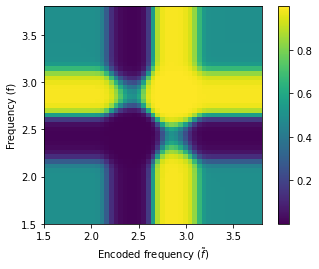

In [5]:
"""
Three tones
Perceptual tones have a longer range than the experimental tones.
This code snippet plots the posterior p(H|T_p1, T_p2, T_p3)
"""
# Parameters
trial_tones = np.copy(training_trials)
size = 1; n_tones = 3

log_freq_percept = np.arange(np.log10(expt_tones[0])-0.5, np.log10(expt_tones[-1])+0.5, 0.05) 

_, _, _, _, posterior = \
posterior_array(log_freq_percept, n_tones=n_tones, p_back=0.3, p_low=0.5, \
               log_prior_low=low_dist, log_prior_high=high_dist)

fig = plt.figure()
ax = fig.add_subplot(111)
colormap = ax.imshow(posterior[:,:,0], extent=[log_freq_percept[0], log_freq_percept[-1], \
                                               log_freq_percept[-1], log_freq_percept[0]])
cbar = plt.colorbar(colormap, ax=ax)
ax.invert_yaxis()
ax.set_xlabel('Encoded frequency ($\~{f}$)')
ax.set_ylabel('Frequency (f)')
plt.show()

In [6]:
"""
Trying two routes - 1. what if we have both sensory noise in that the perceived tones are from a gaussian 
whose mean is the true tone and we have decision noise in that the at a particular perceived tone the observer 
chooses high with probability p(H|T). So a trial is basically defined as [trial_tone, perceived_tone and decision]
2. what if we only have sensory noise and the decision made is the best decision at a particular perceived tone. 

"""    

all_trial_tones = np.empty((len(trial_tones)*size,n_tones))
all_trial_behaviour = np.empty((len(trial_tones)*size,1))
prob_trial_behaviour = np.empty((len(trial_tones),1))
probability_high = np.zeros((len(trial_tones),1))
probability_high_given_tone = np.zeros((len(trial_tones),n_tones))

for i_stim in range(len(trial_tones)):
    input_array = np.random.normal(loc=np.log10(trial_tones[i_stim]),scale=0.1,size=(size,1,n_tones)) \
    #pick tones from the gaussian with mean as log(true_tone) and sigma 0.1    
    for i_tperc in range(size):
        perc_tone_idxs = np.zeros((n_tones,1),dtype=int)
        for i in range(n_tones):
            perc_tone_idxs[i] = np.argmin(np.abs(log_freq_percept-input_array[i_tperc][0][i]))
            # find relevant adjacent freq percepts   
        posterior_perc_tone = posterior[perc_tone_idxs[0],perc_tone_idxs[1],perc_tone_idxs[2]]
        # trial_behaviour = (np.random.random_sample() < np.squeeze(posterior_perc_tone)).astype(int)
        # this encodes decision noise
        trial_behaviour = np.squeeze(posterior_perc_tone) > 0.5
        # this makes the same choice for one tone percept every time that tone is perceived   
        all_trial_behaviour[i_stim*size+i_tperc,:] = trial_behaviour
    all_trial_tones[i_stim*size:(i_stim+1)*size,:] = trial_tones[i_stim]    
    prob_trial_behaviour[i_stim] = np.mean(all_trial_behaviour[i_stim*size:(i_stim+1)*size])
    
    gaussian_array_0 = np.expand_dims(gaussian(log_freq_percept, mean = np.log10(trial_tones[i_stim][0]), \
                                            sigma = 0.1), axis = 1)
    gaussian_array_1 = np.expand_dims(gaussian(log_freq_percept, mean = np.log10(trial_tones[i_stim][1]), \
                                            sigma = 0.1), axis = 1)
    gaussian_array_2 = np.expand_dims(gaussian(log_freq_percept, mean = np.log10(trial_tones[i_stim][2]), \
                                            sigma = 0.1), axis = 1)
    gaussian_array_mat = np.expand_dims(gaussian_array_0@np.transpose(gaussian_array_1),\
                                        axis=2)@np.transpose(gaussian_array_2)             
    gaussian_array_mat /= np.sum(gaussian_array_mat)
    probability_high[i_stim] = np.sum(np.multiply(posterior>0.5, gaussian_array_mat))
    
"""
Shuffling the tones and the behaviour to simluate an experiment
"""
s = np.arange(all_trial_tones.shape[0])
np.random.shuffle(s)
all_trial_tones = all_trial_tones[s]
all_trial_behaviour = all_trial_behaviour[s]


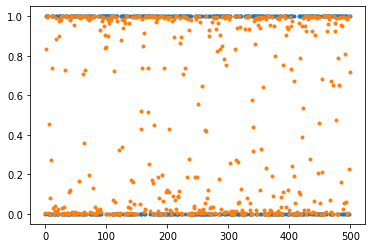

In [7]:
plt.plot(prob_trial_behaviour,'.')
plt.plot(probability_high,'.')

In [8]:
# define mle function
def MLE(params):
    log_prior_low_mean, log_prior_low_sigma, log_prior_high_mean, log_prior_high_sigma, p_back = \
    params[0], params[1], params[2], params[3], params[4] # inputs are guesses at our parameters
    
    prior_low = gaussian(x=log_freq_percept, mean=log_prior_low_mean, sigma=log_prior_low_sigma)
    prior_high = gaussian(x=log_freq_percept, mean=log_prior_high_mean, sigma=log_prior_high_sigma)
    prior_dist_mixed_high = p_back*(1/len(log_freq_percept)) + (1-p_back)*prior_high #mixture model
    prior_dist_mixed_high /= prior_dist_mixed_high.sum() #normalizing
    prior_dist_mixed_high = np.expand_dims(prior_dist_mixed_high, axis = 1)
    prior_dist_mixed_low = p_back*(1/len(log_freq_percept)) + (1-p_back)*prior_low #mixture model
    prior_dist_mixed_low /= prior_dist_mixed_low.sum() #normalizing
    prior_dist_mixed_low = np.expand_dims(prior_dist_mixed_low, axis = 1)

    if len(all_trial_tones[0]) == 3:
        prior_tones_low = np.expand_dims(prior_dist_mixed_low@np.transpose\
                                         (prior_dist_mixed_low),axis=2)@np.transpose(prior_dist_mixed_low) \
        #p(T1,T2..|L) 
        prior_tones_high = np.expand_dims(prior_dist_mixed_high@np.transpose\
                                          (prior_dist_mixed_high),axis=2)@np.transpose(prior_dist_mixed_high) \
        #p(T1,T2..|H) 
        
    elif len(all_trial_tones[0]) == 2:
        prior_tones_low = prior_dist_mixed_low@np.transpose(prior_dist_mixed_low)
        #p(T1,T2..|L) 
        prior_tones_high = prior_dist_mixed_high@np.transpose(prior_dist_mixed_high)
        #p(T1,T2..|H) 
        
    elif len(all_trial_tones[0]) == 1:
        prior_tones_low = prior_dist_mixed_low
        prior_tones_high = prior_dist_mixed_high
    
    p_low = 0.5 
    normalizer = (1-p_low)*prior_tones_high + p_low*prior_tones_low #p(H)*p(T1,T2..|H) + p(L)*p(T1,T2..|L)
    posterior = prior_tones_high*(1-p_low)/normalizer  
        
    neg_ll = 0; 
    probability_high = np.zeros((len(all_trial_tones),1))
    for i_etrial in range(len(all_trial_tones)):
        gaussian_array_0 = np.expand_dims(gaussian(log_freq_percept, \
                                                   mean = np.log10(all_trial_tones[i_etrial][0]), \
                                                   sigma = 0.1), axis = 1)
        gaussian_array_1 = np.expand_dims(gaussian(log_freq_percept, \
                                                   mean = np.log10(all_trial_tones[i_etrial][1]), \
                                                   sigma = 0.1), axis = 1)
        gaussian_array_2 = np.expand_dims(gaussian(log_freq_percept, \
                                                   mean = np.log10(all_trial_tones[i_etrial][2]), \
                                                   sigma = 0.1), axis = 1)
        gaussian_array_mat = np.expand_dims(gaussian_array_0@np.transpose(gaussian_array_1),\
                                    axis=2)@np.transpose(gaussian_array_2)  
        gaussian_array_mat /= np.sum(gaussian_array_mat)
        probability_high[i_etrial] = np.sum(np.multiply(posterior>0.5, gaussian_array_mat))   

        if all_trial_behaviour[i_etrial]:
            neg_ll += -np.log(probability_high[i_etrial] + np.finfo(float).eps)\
            # if high dist is chosen by observer
        else:
            neg_ll += -np.log(1 - probability_high[i_etrial]+ np.finfo(float).eps) \
            # if low dist is chosen by observer
        if np.isnan(np.log(probability_high[i_etrial] + 0.00001)) \
        or np.isinf(np.log(probability_high[i_etrial] + 0.00001)) \
        or np.isnan(np.log(1 - probability_high[i_etrial] + 0.00001)) \
        or np.isinf(np.log(1 - probability_high[i_etrial] + 0.00001)):
            pdb.set_trace()        
    return(neg_ll)

In [9]:
guess_low_mean = np.arange(2,2.6,0.05); guess_low_sigma = np.arange(0.05,0.2,0.05)
guess_high_mean = np.arange(2.6,3.2,0.05); guess_high_sigma = np.arange(0.05,0.2,0.05)
guess_p_back = np.arange(0.1,1,0.1); guess_p_low = np.arange(0.2,0.8,0.1)
"""
Constraining guesses of means of low and high distributions based on observed behaviour in figure shown above. 
Currently estimating only means and p_back.
"""
neg_ll_array = np.zeros((len(guess_low_mean),len(guess_low_sigma),\
                         len(guess_high_mean),len(guess_high_sigma),len(guess_p_back)))
for lm in tqdm(range(len(guess_low_mean))):
    for ls in tqdm(range(len(guess_low_sigma)), leave=False, desc="Low sigma"):
        for hm in range(len(guess_high_mean)):
            for hs in range(len(guess_high_sigma)):
                for pb in range(len(guess_p_back)):
                    # for pl in range(len(guess_p_low)):
                    params = [guess_low_mean[lm], guess_low_sigma[ls], guess_high_mean[hm], \
                              guess_high_sigma[hs], guess_p_back[pb]] # guess_p_low[pl]]
                    # print(lm, hm, pb)
                    neg_ll_array[lm,ls,hm,hs,pb] = MLE(params)      

In [12]:
# Means and p_back corresponding to the least negative log likelihood value
idxs = np.where(neg_ll_array == np.amin(neg_ll_array)) 
guess_low_mean[idxs[0]], guess_low_sigma[idxs[1]],  guess_high_mean[idxs[2]], \
guess_high_sigma[idxs[3]], guess_p_back[idxs[4]], np.amin((neg_ll_array))

(array([2.45]),
 array([0.1]),
 array([2.85]),
 array([0.15]),
 array([0.6]),
 69.21485572033588)

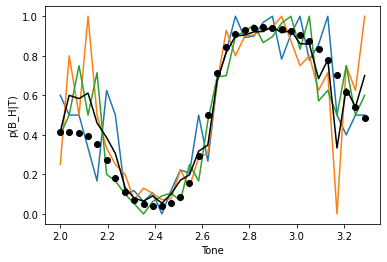

In [20]:
# Influence plots the way we currently understand them (11-17-2020)

unique_tones = np.unique(all_trial_tones)
tone1_prob_behaviour = np.zeros((log_freq_seq_array.shape))
tone2_prob_behaviour = np.zeros((log_freq_seq_array.shape))
tone3_prob_behaviour = np.zeros((log_freq_seq_array.shape))

for i_tone in range(len(unique_tones)):
    tone1_prob_behaviour[i_tone] = np.mean(all_trial_behaviour[all_trial_tones[:,0]\
                                                       ==unique_tones[i_tone]])
    tone2_prob_behaviour[i_tone] = np.mean(all_trial_behaviour[all_trial_tones[:,1]\
                                                       ==unique_tones[i_tone]])
    tone3_prob_behaviour[i_tone] = np.mean(all_trial_behaviour[all_trial_tones[:,2]\
                                                       ==unique_tones[i_tone]])
plt.plot(np.log10(unique_tones), tone1_prob_behaviour)
plt.plot(np.log10(unique_tones), tone2_prob_behaviour)
plt.plot(np.log10(unique_tones), tone3_prob_behaviour)
"""
tone1_prob_behaviour = np.zeros((log_freq_seq_array.shape))
tone2_prob_behaviour = np.zeros((log_freq_seq_array.shape))
tone3_prob_behaviour = np.zeros((log_freq_seq_array.shape))

for i_tone in range(len(unique_tones)):
    tone1_prob_behaviour[i_tone] = np.mean(prob_trial_behaviour[trial_tones[:,0]\
                                                       ==unique_tones[i_tone]])
    tone2_prob_behaviour[i_tone] = np.mean(prob_trial_behaviour[trial_tones[:,1]\
                                                       ==unique_tones[i_tone]])
    tone3_prob_behaviour[i_tone] = np.mean(prob_trial_behaviour[trial_tones[:,2]\
                                                       ==unique_tones[i_tone]])
plt.plot(tone1_prob_behaviour)
plt.plot(tone2_prob_behaviour)
plt.plot(tone3_prob_behaviour)

tone1_prob_behaviour = np.zeros((log_freq_seq_array.shape))
tone2_prob_behaviour = np.zeros((log_freq_seq_array.shape))
tone3_prob_behaviour = np.zeros((log_freq_seq_array.shape))

for i_tone in range(len(unique_tones)):
    tone1_prob_behaviour[i_tone] = np.mean(probability_high[trial_tones[:,0]\
                                                       ==unique_tones[i_tone]])
    tone2_prob_behaviour[i_tone] = np.mean(probability_high[trial_tones[:,1]\
                                                       ==unique_tones[i_tone]])
    tone3_prob_behaviour[i_tone] = np.mean(probability_high[trial_tones[:,2]\
                                                       ==unique_tones[i_tone]])
plt.plot(tone1_prob_behaviour)
plt.plot(tone2_prob_behaviour)
plt.plot(tone3_prob_behaviour)

for i_stim in range(len(trial_tones)):
    _, _, true_tone_high_prior, true_tone_low_prior, _ = \
    posterior_array(log_freq_seq_array, n_tones=2, p_back=0.3, p_low=0.5, \
                    log_prior_low=low_dist, log_prior_high=high_dist)
    for i_tone in range(n_tones): 
        i_tone_left = np.delete(range(n_tones),i_tone)
        freq_idx0 = np.where(unique_tones==trial_tones[i_stim][i_tone_left[0]])[0]
        freq_idx1 = np.where(unique_tones==trial_tones[i_stim][i_tone_left[1]])[0]
        probability_high_given_tone[i_stim,i_tone] = probability_high[i_stim]*\
        (true_tone_high_prior[freq_idx0,freq_idx1]*0.5+\
         true_tone_low_prior[freq_idx0,freq_idx1]*0.5)

tone1_prob_behaviour = np.zeros((log_freq_seq_array.shape))
tone2_prob_behaviour = np.zeros((log_freq_seq_array.shape))
tone3_prob_behaviour = np.zeros((log_freq_seq_array.shape))

for i_tone in range(len(unique_tones)):
    tone1_prob_behaviour[i_tone] = \
    np.mean(probability_high_given_tone[trial_tones[:,0]==unique_tones[i_tone],0])
    tone2_prob_behaviour[i_tone] = \
    np.mean(probability_high_given_tone[trial_tones[:,1]==unique_tones[i_tone],1])
    tone3_prob_behaviour[i_tone] = \
    np.mean(probability_high_given_tone[trial_tones[:,2]==unique_tones[i_tone],2])
plt.plot((tone1_prob_behaviour+tone2_prob_behaviour+tone3_prob_behaviour)*150/3)
"""
y = (tone1_prob_behaviour+tone2_prob_behaviour+tone3_prob_behaviour)/3
x = np.log10(unique_tones)
plt.plot(np.log10(unique_tones), (tone1_prob_behaviour+tone2_prob_behaviour+tone3_prob_behaviour)/3,'k')

_, _, _, _, posterior = \
posterior_array(log_freq_seq_array, n_tones=1, p_back=guess_p_back[idxs[4]], p_low=0.5, \
               log_prior_low=[guess_low_mean[idxs[0]], guess_low_sigma[idxs[1]]],\
                log_prior_high=[ guess_high_mean[idxs[2]], guess_high_sigma[idxs[3]]])
plt.plot(np.log10(unique_tones), posterior,'ko')
plt.xlabel('Tone')
plt.ylabel('p(B_H|T)')

plt.savefig('figures/experimenter=simulations_300_2000hz_range.png')

Parameter type | Parameter value | Standard error | t | P > np.abs(t) (p-value)
Beta | 0.417 | 0.065 | 6.456 | 0.0
Beta | 4.898 | 2.439 | 2.009 | 0.058
Beta | -7.305 | 2.459 | -2.971 | 0.008
Beta | 3.408 | 0.443 | 7.684 | 0.0
Beta | 5.008 | 1.209 | 4.141 | 0.001
Beta | -6.408 | 1.182 | -5.421 | 0.0
Beta | -9.362 | 25.15 | -0.372 | 0.714
Beta | 12.339 | 24.295 | 0.508 | 0.617
Breakpoint | 2.057 | 0.016 | 129.702 | 0.0
Breakpoint | 2.341 | 0.021 | 114.154 | 0.0
Breakpoint | 2.608 | 0.018 | 145.508 | 0.0
Breakpoint | 2.722 | 0.014 | 199.138 | 0.0
Breakpoint | 3.13 | 0.01 | 306.958 | 0.0
Breakpoint | 3.171 | 0.085 | 37.085 | 0.0


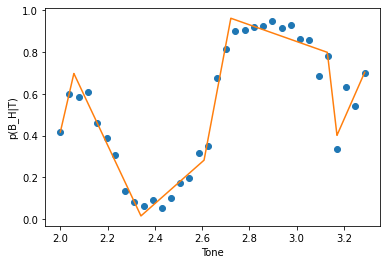

In [22]:
y = (tone1_prob_behaviour+tone2_prob_behaviour+tone3_prob_behaviour)/3
x = np.log10(unique_tones)

# initialize piecewise linear fit with your x and y data
my_pwlf = pwlf.PiecewiseLinFit(x, y)

# fit the data with line segments
res = my_pwlf.fit(7)

# predict for the determined points
xHat = np.linspace(min(x), max(x), num=10000)
yHat = my_pwlf.predict(xHat)

# plot the results
plt.figure()
plt.plot(x, y, 'o')
plt.plot(xHat, yHat, '-')
plt.xlabel('Tone')
plt.ylabel('p(B_H|T)')
plt.savefig('figures/experimenter=simulations_linear_fit.png')

p = my_pwlf.p_values(method='non-linear', step_size=1e-4)
se = my_pwlf.se  # standard errors

parameters = np.concatenate((my_pwlf.beta,
                             my_pwlf.fit_breaks[1:-1]))

header = ['Parameter type', 'Parameter value', 'Standard error', 't',
          'P > np.abs(t) (p-value)']
print(*header, sep=' | ')
values = np.zeros((parameters.size, 5), dtype=np.object_)
values[:, 1] = np.around(parameters, decimals=3)
values[:, 2] = np.around(se, decimals=3)
values[:, 3] = np.around(parameters / se, decimals=3)
values[:, 4] = np.around(p, decimals=3)

for i, row in enumerate(values):
    if i < my_pwlf.beta.size:
        row[0] = 'Beta'
        print(*row, sep=' | ')
    else:
        row[0] = 'Breakpoint'
        print(*row, sep=' | ')

In [14]:
from sympy import Symbol
from sympy.utilities import lambdify
x = Symbol('x')


def get_symbolic_eqn(pwlf_, segment_number):
    if pwlf_.degree < 1:
        raise ValueError('Degree must be at least 1')
    if segment_number < 1 or segment_number > pwlf_.n_segments:
        raise ValueError('segment_number not possible')
    # assemble degree = 1 first
    for line in range(segment_number):
        if line == 0:
            my_eqn = pwlf_.beta[0] + (pwlf_.beta[1])*(x-pwlf_.fit_breaks[0])
        else:
            my_eqn += (pwlf_.beta[line+1])*(x-pwlf_.fit_breaks[line])
    # assemble all other degrees
    if pwlf_.degree > 1:
        for k in range(2, pwlf_.degree + 1):
            for line in range(segment_number):
                beta_index = pwlf_.n_segments*(k-1) + line + 1 
                my_eqn += (pwlf_.beta[beta_index])*(x-pwlf_.fit_breaks[line])**k
    return my_eqn.simplify()


eqn_list = []
f_list = []
for i in range(my_pwlf.n_segments):
    eqn_list.append(get_symbolic_eqn(my_pwlf, i + 1))
    print('Equation number: ', i + 1)
    print(eqn_list[-1])
    f_list.append(lambdify(x, eqn_list[-1]))

Equation number:  1
4.89871421028826*x - 9.38076391574345
Equation number:  2
5.64966450290487 - 2.40699579736458*x
Equation number:  3
1.00059142612067*x - 2.32804251485643
Equation number:  4
6.00877916295542*x - 15.3905849990973
Equation number:  5
2.04868691032219 - 0.399101599387402*x
Equation number:  6
48.3611144654815 - 15.1922974557624*x
Equation number:  7
2.57877465265585*x - 7.77581820565499


In [ ]:
for i in range(len(unique_tones)):    
    print(unique_tones[i],np.sum(all_trial_tones[:,0]==unique_tones[i]))